In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# <span style="color:orange"> Numerical Simulation Laboratory: Lecture 09</span>

## Exercise 09.1
We use a genetical algorithm to solve two travelling salesman problems for $N=32$ cities placed
1. on a circumference
2. inside a square

Let $\{\vec{x}_i\}_{i=1}^{N}$ be the positions of the cities in either of the two configurations.
For the sake of simplicity, we are going to fix $\vec{x}_1$ as the starting city of all the paths and are going to use as the cost function:
$$
L_1(\sigma):=\lVert\vec{x}_{\sigma(N)}-\vec{x}_{1}\rVert+\sum_{i=1}^{N-1}\lVert\vec{x}_{\sigma(i)}-\vec{x}_{\sigma(i+1)}\rVert
$$
where $\sigma\in S_{N}$ is a permutation on $\{1,\dots, N\}$ such that $1$ is a fixed point (i.e. $\sigma(1)=1$). There are of course $(N-1)!$ such functions and algorithm should be able to identify the permutation $\sigma^*$ such that $$L_1(\sigma^*)=\min_{\substack{\sigma\in S_{N}\\\sigma(1)=1}}\bigl\{L_1(\sigma)\bigr
\}$$
Actually, for fixed $\sigma$, the paths $\{1,\sigma(2),\dots, \sigma(N)\}$ and $\{1,\sigma(N), \dots, \sigma(2)\}$ share the same length $L_1$, so it is natural to identify them as one (they only differ in the walking "direction"). Hence, the number of indipendent permutation is $(N-1)!/2$.

### 09.1.1 Mutations
At each generation of the GA, the following mutations may occur with a given probability:
1. Pair permutation (exchange of two cities).
2. Block permutation (exchange of two blocks of contiguous cities of equal length).
3. Shift (shift of a block of contiguous cities by a certain number of positions).
4. Inversion (reflection of a block of contiguous cities).
5. Crossover.

The choice of the paths that may undergo such mutations is to be done according to a "natural selection" rule: the less their cost function is, the more they should be able to replicate. It is therefore convenient to sort the population according to $L_1$ in such a way that the first elements will be the "fittest" and then rig the selection algorithm so that it will more easily yield low integers. Accordingly, we will choose the "positions" of the paths that may undergo mutations in our ordered population with the rule $n={\rm int}(Nr^q)$ where $r\sim\mathcal{U}(0,1)$ and $q=1.6$.

The starting population is built by application of the pair permutation mutation to the ordered path $\{1,\dots,32\}$ recursively (i.e. the $(n+1)$-th individual is a mutation of the $n$-th).

### 09.1.2 Genetical Algorithm code
The GA is implemented as follows:
- The positions of the cities are stored in the following class:
```C++
class Cities {
	protected:
	Random m_gen;
	int m_ncities;
	Posizione* m_positions;

	public:
	// constructor(s)
	Cities();
	// methods to place cities
	void Cities_in_circle(int ncities, double r);		// cities on a circle of given radius
	void Cities_in_square(int ncities, double side);	// cities in a square of given side
	// 
	double Calculate_distance(int i, int j) const { return (m_positions[i]-m_positions[j]).GetR(); };
	int GetNcities() const { return m_ncities; };
	void Print(ofstream& fout) const;
};
```
where <code>class Posizione</code> is the same as in the codes from Lec. 2.
- The paths are represented as collection of $N$ integers subject to a given permutation and stored thanks to the following class, which also takes care of the mutations:
```C++
class item{
	vector<int> m_person;
	int m_size;
	double m_L1, m_L2;
	double m_probPP, m_probS, m_probP, m_probI;

	protected:
	int Next(int i) const;

	public:
	// constructor
	item(const Cities c);
	item(item i0, int i, int j, const Cities c);
	item(item i0, const Cities c);
	// Access to private members
	int GetSize() const { return m_size; };
	int operator[](int i) const { return m_person[i]; };
	vector<int> GetPerson() const { return m_person; };
	double GetL1() const { return m_L1; };
	double GetL2() const { return m_L2; };
	// calculate lengths
	void Calculate_L1(const Cities c);
	void Calculate_L2(const Cities c);
	// mutations
    void Mutate(const Cities c, Random& m_gen);                              // runs all mutations at once
	void GM_Pair_Permutation(const Cities c, Random& m_gen);
	void GM_Shift(const Cities c, Random& m_gen);
	void GM_Block_Permutation(const Cities c, Random& m_gen);
	void GM_Inversion(const Cities c, Random& m_gen);	
	// crossover
	vector<int> Crossover(int cut, vector<int> consort, const Cities c); 		// returns old m_person
	// print
	void PrintPath(ofstream& fout);
};
```
The mutation probabilities are set to $P_{p.p.}=P_{s}=P_{inv}=0.05$ and $P_{b.p}=0.08$. The crossover probability is not stored here because it is the only mutation that involves more than one path.
3. The population (i.e. a collection of <code>item</code>-s) is given by the following class:
```C++
class Population{
	int m_size;
	double m_probC;
	vector<item> m_pop;
	Random m_gen;
	Cities* m_c;

	protected:
	// rigged selector
	int Select();

	public:
	// constructor(s)
	Population(int npop, Cities c);
	// sort
	void SortL1();
	void SortL2();
	// new generation creator
	void New_generation();
	// print
	void PrintPath(ofstream& fout, int cut);
	void PrintL1(ofstream& fout, int cut);
	void PrintL2(ofstream& fout, int cut);
};
```
The crossover probability is $P_{cross}=0.7$. The sorting methods rely on the following namespace:
```C++
namespace sortcryteria{
	bool sort_by_L1(item a, item b) { return a.GetL1() < b.GetL1(); };
	bool sort_by_L2(item a, item b) { return a.GetL2() < b.GetL2(); };
}
```
as well as on the <code>sort</code> algorithm from the library <code>algorithm.h</code> from STL.

### 09.1.3 Cities on a circumference
We randomly place the $N=32$ cities on a circumference of radius $r=1$ (i.e. we extract $N$ polar angles $\{\varphi_n\}\sim\mathcal{U}(0,2\pi)$). The GA is run for $2000$ generations and with a population of $300$ paths (number of items kept constant). We print the optimizing path as well as the behaviour of the cost function for the best path as the generation number increases and its average on the first half of the population (the best $150$ paths from each generation).

In [2]:
def load_path(filename, Ncities):
    c=np.zeros((2, Ncities))
    cord=np.zeros((2, Ncities+1))
    ind=np.zeros(Ncities)

    i=0
    file=open("Es_lezione_09/cities_in_"+ filename + ".dat")
    for line in file.readlines():
        c[0][i]=float(line.split()[0])
        c[1][i]=float(line.split()[1])
        i+=1

    file.close()

    file=open("Es_lezione_09/pop_"+ filename + "_best_path.dat")
    l=file.readline().split()
    ind=[int(j) for j in l]
    file.close() 

    for j in range(Ncities):
        for k in range(2):
            cord[k][j]=c[k][ind[j]-1]
    for k in range(2):
        cord[k][Ncities]=c[k][0]
    
    return c, cord

In [3]:
def average(sample, dim):
    s=0
    for data in sample:
        s+=data
    return s/dim

def load_L(filename, L, Ngen, Npop):
    L1=np.zeros((Ngen, Npop))
    L1best=np.zeros(Ngen)
    L1ave=np.zeros(Ngen)
    
    file=open("Es_lezione_09/pop_"+ filename + "_" + L + ".dat")
    i=0
    j=0
    for line in file:
        if(line=="\n"):
            i+=1
            j=0
        else:
            L1[i][j]=float(line)
            j+=1
    file.close()

    for k in range(Ngen):
        L1best[k]=L1[k][0]
        L1ave[k]=average(L1[k], Npop)
    return L1best, L1ave

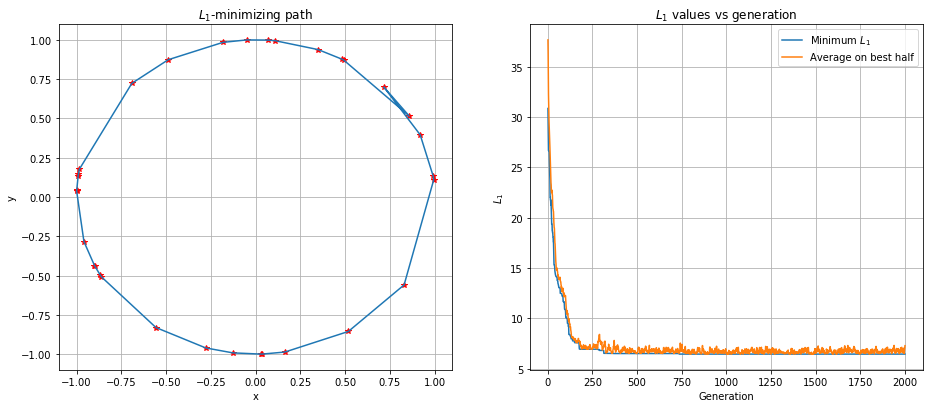

In [4]:
Ncities=32
Ngen=2000
Npop=150

x=np.arange(1, Ngen+1)
c, cord=load_path("circle", Ncities)
L1best, L1ave=load_L("circle", "L1", Ngen, Npop)

f, canvas=plt.subplots(nrows=1, ncols=2)

canvas[0].plot(c[0], c[1], 'r*', label="Cities")
canvas[0].plot(cord[0], cord[1], label="Minimizing path")
canvas[0].grid(True)
canvas[0].set_title("$L_1$-minimizing path")
canvas[0].set_xlabel("x")
canvas[0].set_ylabel("y")

canvas[1].plot(x, L1best, label="Minimum $L_1$")
canvas[1].plot(x, L1ave, label="Average on best half")
canvas[1].grid(True)
canvas[1].legend()
canvas[1].set_title("$L_1$ values vs generation")
canvas[1].set_xlabel("Generation")
canvas[1].set_ylabel("$L_1$")

plt.subplots_adjust(left=0, bottom=0, right=2, top=1.2, wspace=0.2, hspace=0.4)

As expected, the shortest path follows the shape of the circumference. From the $L_1$ plot we see that it is reached after about $750$ generations and that it steadily replicates from then on. We also notice that the average $L_1$ on the best half is always higher than the minimum. This is a consequence of the rather mild natural selection we have set on our system by choosing a value for the exponent $q$ in the rigged selection not very far from $1$. Had we picked a higher value, we would have seen a quicker convergence but it may have been too fast and the system might have got stuck in a local minimum and would have been unable to escape from it due to all the elements turning into a replicate of the local best in a very low number of generations (even though we could have made up for that by increasing the mutation probabilities).  

### 09.1.4 Cities in a square
We place the cities in a square of side $\ell=1$ with kind of the same philosphy of the previous case (i.e. we extract $2N$ values $\{x_n\},\{y_n\}\sim\mathcal{U}(0,\ell)$) and run the GA with the same parameters ($2000$ generations of $300$ individuals each).

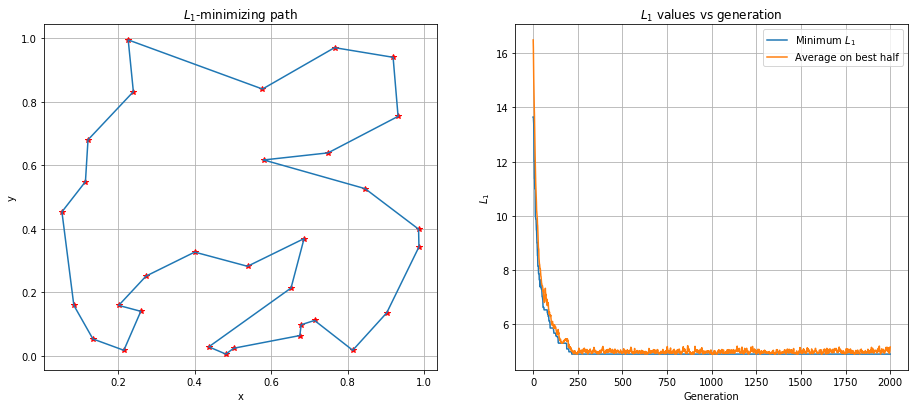

In [5]:
c, cord=load_path("square", Ncities)
L1best, L1ave=load_L("square", "L1", Ngen, Npop)

fsq, canvasq=plt.subplots(nrows=1, ncols=2)

canvasq[0].plot(c[0], c[1], 'r*', label="Cities")
canvasq[0].plot(cord[0], cord[1], label="Minimizing path")
canvasq[0].grid(True)
canvasq[0].set_title("$L_1$-minimizing path")
canvasq[0].set_xlabel("x")
canvasq[0].set_ylabel("y")

canvasq[1].plot(x, L1best, label="Minimum $L_1$")
canvasq[1].plot(x, L1ave, label="Average on best half")
canvasq[1].grid(True)
canvasq[1].legend()
canvasq[1].set_title("$L_1$ values vs generation")
canvasq[1].set_xlabel("Generation")
canvasq[1].set_ylabel("$L_1$")

plt.subplots_adjust(left=0, bottom=0, right=2, top=1.2, wspace=0.2, hspace=0.4)

The best individual is already stabilized after roughly $250$ generations, once again the effects of the mild natural selection are visible in the averages on the best half of the population, even though the oscillations appear to be smaller than the previous case. 